# Неделя 7. Градиентный бустинг.

[Ссылка на форму с вопросами](https://forms.gle/gPevc4GKscG2wiWo6) 

Дэдлайн: **8.04.20** включительно. 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from tqdm.notebook import tqdm
from xgboost import XGBRegressor

%pylab inline

RANDOM_SEED = 0

Populating the interactive namespace from numpy and matplotlib


# Устнановка модулей нужной версии, в случае необходимости.
!pip install xgboost==1.0.2
!pip install scikit-learn==0.22.1
!pip install hyperopt==0.2.3

In [2]:
#!pip install xgboost==1.0.2

In [3]:
#!pip install hyperopt==0.2.3

In [4]:
#!conda update scikit-learn

In [5]:
# Проверка версий библиотек
# Sklearn: 0.22.1,
# XGBoost: 1.0.2
# hyperopt: 0.2.3
import xgboost
import sklearn
import hyperopt
print('Sklearn: {},\nXGBoost: {},\nhyperopt: {}'.format(sklearn.__version__, 
                                                        xgboost.__version__, 
                                                        hyperopt.__version__))

Sklearn: 0.22.1,
XGBoost: 1.0.2,
hyperopt: 0.2.3


## Данные для эксперимента

In [6]:
# Загрузим датасет california_housing
clf_dataset = fetch_california_housing()

In [7]:
data = clf_dataset.data
target = clf_dataset.target
data.shape, target.shape

((20640, 8), (20640,))

In [8]:
# Сделаем случайную выборку из 2000 объектов
n_samples = 2000
np.random.seed(RANDOM_SEED)
samples = np.random.choice(np.arange(data.shape[0]), n_samples, replace=False)
data = data[samples]
target = target[samples]
data.shape, target.shape

((2000, 8), (2000,))

In [9]:
# Сформируем датафрейм из новой выборки, объединив его с таргетом
full_df = pd.DataFrame(data, columns=['clm_{}'.format(i) for i in range(data.shape[1])])
full_df['target'] = target
full_df.head()

,clm_0,clm_1,clm_2,clm_3,clm_4,clm_5,clm_6,clm_7,target
0,4.1518,22.0,5.663073,1.075472,1551.0,4.180593,32.58,-117.05,1.369
1,5.7796,32.0,6.107226,0.927739,1296.0,3.020979,33.92,-117.97,2.413
2,4.3487,29.0,5.930712,1.026217,1554.0,2.910112,38.65,-121.84,2.007
3,2.4511,37.0,4.992958,1.316901,390.0,2.746479,33.20,-115.60,0.725
4,5.0049,25.0,4.319261,1.039578,649.0,1.712401,37.79,-122.43,4.600


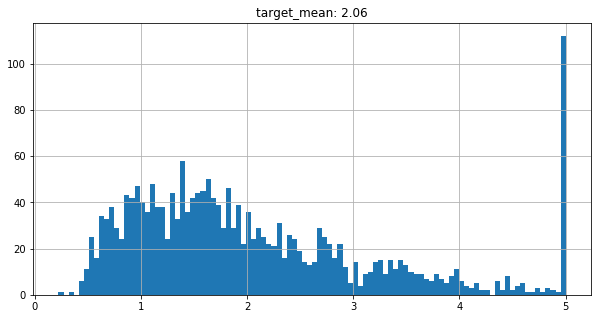

In [10]:
# Посмотрим на таргет
plt.figure(figsize=(10,5))
plt.title('target_mean: {}'.format(round(full_df['target'].mean(), 3)))
full_df['target'].hist(bins=100);

- Таргет вещественный, значит будем решать задачу регрессии.
- Есть выброс в районе 5, на который пока не обращаем внимание.

In [11]:
# Разделим выборку на обучающую и тестовую
X_train, X_test, y_train, y_test = train_test_split(full_df.drop('target', axis=1), 
                                                    full_df['target'], 
                                                    test_size=0.3, 
                                                    random_state=RANDOM_SEED)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1400, 8), (600, 8), (1400,), (600,))

## Константная модель

In [12]:
y_trn_pred = [y_train.mean()]*len(y_train)
y_tst_pred = [y_train.mean()]*len(y_test)
mse_train = mean_squared_error(y_train, y_trn_pred)
mse_test = mean_squared_error(y_test, y_tst_pred)
print('rmse_train: {}, rmse_test: {}'.format(round(np.sqrt(mse_train), 3), round(np.sqrt(mse_test), 3)))

rmse_train: 1.184, rmse_test: 1.161


- Пока полученные цифры нам мало о чем говорят, разве что train и test выборки сбалансированные, так как метрики на train и test близки.
- Но мы можем зафиксировать значение mse_test = 1.16 как бейзлайн, на который будем ориентироваться при построение более сложных моделей.

## Реализация градиентного бустинга

### Определим функцию для расчета вектора сдвигов S
Выберем в качестве функции потерь MSE:

   \\[L=(y-y_{predict})^2\\]
    
Как известно из лекции, для вектор сдвигов представляет собой производную функции потерь, посчитанную на всем объеме выборки:

   \\[s_i =-L'(y_i, y_{predict_i})\\]
         
После вычисления производной получим следующее выражение для определения s. Множитель 2, который получился после дифференцирования квадрата разности, проигнорируем, поскольку в дальнейшем мы будем подбирать множитель базового алгоритма:

   \\[s_i=y_i-y_{predict_i}\\]   
         
    

In [13]:
# Определим функцию для расчета вектора сдвигов S
def S(y_train, y_predict):     
    return list(map(lambda x, y: (x - y), y_train, y_predict))    

### Реализуем алгоритм обучения градиентного бустинга над деревьями
Проинициализируем нашу модель бустинга следующими параметрами:
- Число деревьев: 50
- Коэффициент шага алгоритма: 1.0
- Глубина дерева: 2
- Random_state: 0

    1.Создадим список, где будут храниться наши базовые алгоритмы.
    
    2.Зададимся неким нулевым базовым алгоритмом. Например, константный алгоритм, который на выходе выдает тоже самое, что получает на вход.
    
    3.Обучим в цикле все деревья, научим их приближать вектор сдвигов, расчитанный на основе прогнозов предыдущего базового алгоритма.
    
    4.Получим итоговый прогноз как сумму прогнозов базовых алгоритмов с учетом коэффициента шага.

In [14]:
# Функция вычисления прогноза композиции алгоритмов 
def gbm_predict(X, algo_list, coeff_list):
    predict_lst = []
    for algo, coeff in zip(algo_list, coeff_list):
        predict_lst.append(coeff * algo.predict(X))
    return np.array(predict_lst).sum(axis=0)

In [15]:
# Инициализация параметров модели
n_trees = 50
max_depth = 2
eta = 1.0
eta_list = [eta] * n_trees
y0 = y_train
base_algo_list = []

# Обучение модели
for i in tqdm(range(n_trees)):
    estimator = DecisionTreeRegressor(max_depth=max_depth, random_state=RANDOM_SEED)
    base_algo_list.append(estimator.fit(X_train, S(y_train, y0)))
    y0 = gbm_predict(X_train.values, base_algo_list, eta_list)

# Ответ финальной композиции деревьев
y_pred_test = gbm_predict(X_test.values, base_algo_list, eta_list) 
rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
print(rmse)


0.6590332227577066


### <font color='brown'> Задание №1 </font>
- Используя предложенную выше реализацию GBM, проведите следующий эксперимент: инициализируйте базовый алгоритм медианой таргета обучающей выборки и переобучите модель, обучайте бустинг не меняя параметров инициализации.
- Ответом будет результат rmse, округленный до 4 знака после запятой.

In [16]:
# Инициализация параметров модели
n_trees = 50
max_depth = 2
eta = 1.0
eta_list = [eta] * n_trees
y0 = [y_train.median()]*len(y_train)
base_algo_list = []

# Обучение модели
for i in tqdm(range(n_trees)):
    estimator = DecisionTreeRegressor(max_depth=max_depth, random_state=RANDOM_SEED)
    base_algo_list.append(estimator.fit(X_train, S(y_train, y0)))
    y0 = gbm_predict(X_train.values, base_algo_list, eta_list)

# Ответ финальной композиции деревьев
y_pred_test = gbm_predict(X_test.values, base_algo_list, eta_list) 
rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
print(round(rmse,4))


0.6586


### <font color='brown'> Задание №2 </font>
- Используя предложенную выше реализацию GBM, проведите следующий эксперимент: в качестве базового алгоритма примените линейную модель LinearRegression из sklearn, обучайте бустинг не меняя параметров инициализации.
- Ответье на вопрос: Как повлияла замена базовой модели на итоговую метрику rmse на отложенной выборке. Если метрика изменилась, то объясните почему она изменлась таким образом. Также в конце ответа напшите значение rmse, округленное до 3 знака.

In [50]:
model = LinearRegression()
model.fit(X_train,y_train)
# Инициализация параметров модели
n_trees = 50
max_depth = 2
eta = 1.0
eta_list = [eta] * n_trees
y0 = model.predict(X_train)
base_algo_list = []

# Обучение модели
for i in tqdm(range(n_trees)):
    estimator = DecisionTreeRegressor(max_depth=max_depth, random_state=RANDOM_SEED)
    base_algo_list.append(estimator.fit(X_train, S(y_train, y0)))
    y0 = gbm_predict(X_train.values, base_algo_list, eta_list)

# Ответ финальной композиции деревьев
y_pred_test = gbm_predict(X_test.values, base_algo_list, eta_list) 
rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
print(round(rmse,3))








0.608


Ответ: замена базовой модели на LinearRegression привела к уменьшению rmse по сравнению с предыдущим шагом, это связано с тем, что в качестве базового алгоритма были взяты значения более приближенные к таргету , тем самым подправляя композицию и изменяя алгоритм в направлении антиградиента ошибки.

### Оценим влияние коэффициента шага алгоритма (eta) на ошибку модели
Шаг для всех базовых алгоритмов композиции останется постоянным. Будем менять шаг eta только для всей композиции и оценим его влияние на rmse.

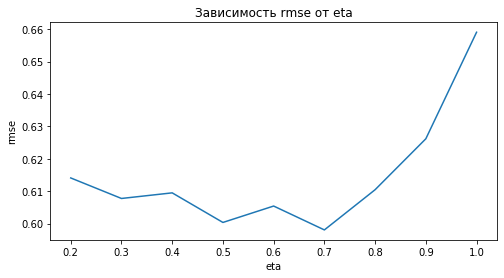

In [18]:
rmse_list = []
for eta in tqdm(np.arange(1.0, 0.1, -0.1)):
    n_trees = 50
    max_depth = 2
    y0 = y_train
    base_algo_list = []
    eta_list = [round(eta, 1)] * n_trees
    # Обучение модели
    for i in range(n_trees):
        estimator = DecisionTreeRegressor(max_depth=max_depth, random_state=RANDOM_SEED)    
        base_algo_list.append(estimator.fit(X_train, S(y_train, y0)))
        y0 = gbm_predict(X_train.values, base_algo_list, eta_list)

    # Ответ финальной композиции деревьев
    y_pred_test = gbm_predict(X_test.values, base_algo_list, eta_list) 
    rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
    rmse_list.append(rmse)
    
plt.figure(figsize=(8,4))
plt.plot(np.arange(1.0, 0.1, -0.1), rmse_list);
plt.title('Зависимость rmse от eta')
plt.xlabel('eta')
plt.ylabel('rmse');

- После значения eta > 0.7 наша можель начинает переобучаться.  

### <font color='brown'> Задание №3 </font>
Недостаток постоянства шага для базовых алгоритмов композиции заключается в том, что ошибки вблизи минимума не могут достигнуть экстремума и постоянно перескакивют его. Поэтому желательно, чтобы с каждым шагом, для нового базового алгоритма параметр eta уменьшался.
- Реализуйте снижение шага eta для базовых алгоритмов в рамках обучения одной композиции по следующему закону:

    \\[eta_i = \frac{1.0}{1.0+0.1*i}\\]
    
    
- Ответом будет результат rmse, округленный до 3 знака после запятой.

In [19]:
#rmse_ = 0
n_trees = 50
max_depth = 2
y0 = y_train
base_algo_list = []
eta_list = [1.0/(1.0+0.1*i) for i in range(n_trees)] #* n_trees# round(eta, 1)
# Обучение модели
for i in range(n_trees):
    estimator = DecisionTreeRegressor(max_depth=max_depth, random_state=RANDOM_SEED)    
    base_algo_list.append(estimator.fit(X_train, S(y_train, y0)))
    y0 = gbm_predict(X_train.values, base_algo_list, eta_list)

# Ответ финальной композиции деревьев
y_pred_test = gbm_predict(X_test.values, base_algo_list, eta_list) 
rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
#rmse_list.append(rmse)    
    
#plt.figure(figsize=(8,4))
#plt.plot(np.arange(1.0, 0.1, -0.1), rmse_list);
#plt.title('Зависимость rmse от eta')
#plt.xlabel('eta')
#plt.ylabel('rmse');

print(round(rmse,3))



0.606


## Работа с раличными реализациями градиентного бустинга
### Оценим влияние различных параметров градиентного бустинга на ошибку модели на примере реализации из sklearn - ***GradientBoostingRegressor***

In [20]:
print('------------------') 
print('Go for estimators..')
n_estim_list = np.arange(2,200,10)
rmse_estim = []
for estimator in tqdm(n_estim_list):
    regressor = GradientBoostingRegressor(n_estimators = estimator, max_depth = 20)
    regressor.fit(X_train, y_train)
    rmse_estim.append(np.sqrt(mean_squared_error(y_test, regressor.predict(X_test)))) 

print('------------------')   
print('Go for max_depth..')
max_depth_list = np.arange(1,100,10)
rmse_depth = []
for depth in tqdm(max_depth_list):
    regressor = GradientBoostingRegressor(n_estimators = 50, max_depth = depth)
    regressor.fit(X_train, y_train)
    rmse_depth.append(np.sqrt(mean_squared_error(y_test, regressor.predict(X_test))))

------------------
Go for estimators..



------------------
Go for max_depth..


Text(0.5, 1.0, 'RMSE for depth')

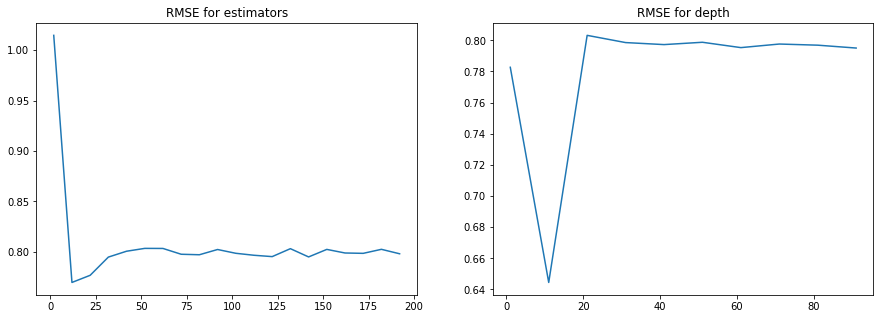

In [21]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(n_estim_list, rmse_estim)
pyplot.title('RMSE for estimators')
    
plt.subplot(1,2,2)
pyplot.plot(max_depth_list, rmse_depth)
pyplot.title('RMSE for depth')

- С увеличением числа деревьев, начиная с некоторого момента, градиентный бустинг начинает переобучаться.
- С ростом глубины деревьев, начиная с некоторого момента, качество работы градиентного бустинга на тестовой выборке также начинает ухудшаться, то есть модель переобучается.


### <font color='brown'> Задание №4 </font>
Оцените влияние параметра ***learning_rate*** (аналог eta) рассмотренной выше модели ***GradientBoostingRegressor*** на RMSE.
- Зафиксируйте параметры модели: n_estimators = 100, max_depth = 2, random_state=RANDOM_SEED.
- Постройте изменение RMSE в зависимости от ***learning_rate*** в диапазоне от 0.1 до 1.0 (включительно) с шагом 0.1 для train и test выборок.
- Оцените значение ***learning_rate*** при котором начинается переобучение. 

Text(0.5, 1.0, 'RMSE for learning rate')

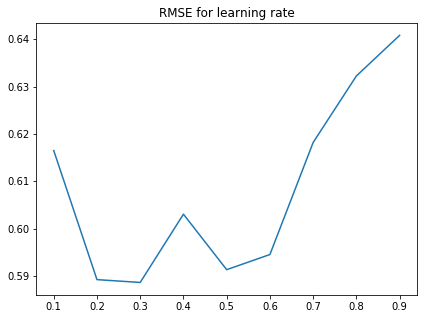

In [51]:

n_estimators = 100
max_depth = 2
random_state = RANDOM_SEED
l_rate_list = np.arange(0.1,1.,0.1)
rmse_l_rate = []
for l_rate in tqdm(l_rate_list):
    regressor = GradientBoostingRegressor(
        learning_rate = l_rate,
        n_estimators = n_estimators, 
        max_depth = max_depth, 
        random_state = random_state)
    
    regressor.fit(X_train, y_train)
    rmse_l_rate.append(np.sqrt(mean_squared_error(y_test, regressor.predict(X_test)))) 

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(l_rate_list, rmse_l_rate)
pyplot.title('RMSE for learning rate')


## XGBoost
### Рассмотрим некоторые удобные функции библиотеки XGBoost:
- Останов по значению метрики на валидации.
- Визуализация.
- Важность признаков


In [24]:
# Обучим модель XGBRegressor c заданным параметром early_stopping_rounds
xgb = XGBRegressor(n_estimators=1000, random_state=RANDOM_SEED)
xgb.fit(X_train, y_train,
        eval_set=[(X_train, y_train),(X_test, y_test)],
        eval_metric='rmse',
        verbose=True,
        early_stopping_rounds=10
        )

[0]	validation_0-rmse:1.45458	validation_1-rmse:1.44774
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:1.09244	validation_1-rmse:1.10456
[2]	validation_0-rmse:0.84538	validation_1-rmse:0.90079
[3]	validation_0-rmse:0.67606	validation_1-rmse:0.77035
[4]	validation_0-rmse:0.56256	validation_1-rmse:0.69454
[5]	validation_0-rmse:0.48822	validation_1-rmse:0.65288
[6]	validation_0-rmse:0.43576	validation_1-rmse:0.63291
[7]	validation_0-rmse:0.39475	validation_1-rmse:0.61375
[8]	validation_0-rmse:0.36269	validation_1-rmse:0.60264
[9]	validation_0-rmse:0.33741	validation_1-rmse:0.59653
[10]	validation_0-rmse:0.32255	validation_1-rmse:0.59534
[11]	validation_0-rmse:0.30436	validation_1-rmse:0.58326
[12]	validation_0-rmse:0.29840	validation_1-rmse:0.58210
[13]	validation_0-rmse:0.28648	validation_1-rmse:0.57860
[14]	validation_0-rmse:0.28122	validation_1-rmse:0.57

XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
             validate_parameters=False, verbosity=None)

- Обучение было остановлено, после того как ошибка rmse не уменьшалась на тестовой выборке в течении **10** итерации.


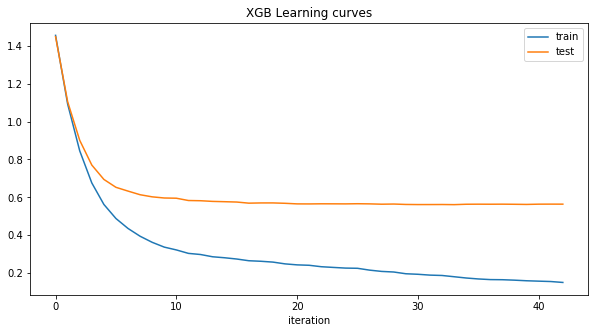

In [25]:
# Построим кривые обучения и валидации с помощью встроенных в XGBoost методов оценки ошибки. 
eval_results = xgb.evals_result()
train_error = eval_results['validation_0']['rmse']
test_error = eval_results['validation_1']['rmse']
df_error = pd.DataFrame([train_error, test_error]).T
df_error.columns = ['train', 'test']
df_error.index.name = 'iteration'
# Plot curves
df_error.plot(title = 'XGB Learning curves', figsize=(10,5));

- По кривым обучения видно, что применение раннего останова обучения позволило избежать переобучения модели.


### <font color='brown'> Задание №5 </font>
Работа с встроенной функцией Feature_importance
- С помощью встроенной в xgboost функции определения важности признаков найдите топ 4 важных признаков и переобучите на них модель.
- Ответом будет метрика rmse, полученная новой моделью на тестовой выборке. Ответ округлите до 3-го знака. 

In [29]:
importances = xgb.feature_importances_

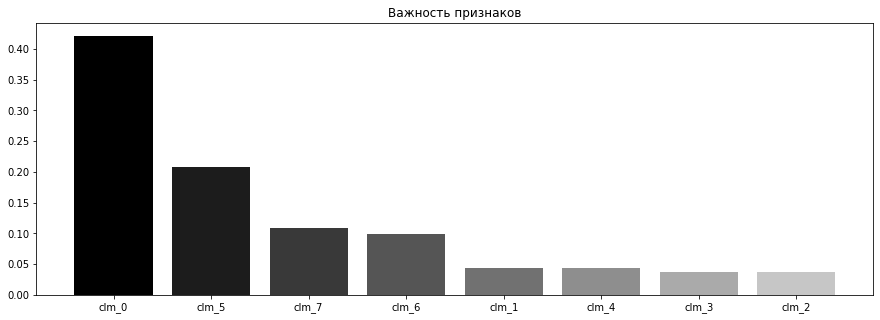

In [31]:
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(15,5))
plt.title("Важность признаков")
bars = plt.bar(X_train.columns[indices], 
               importances[indices],
       color=([str(i/float(len(indices)+1)) 
               for i in range(len(indices))]),
               align="center")

In [34]:
best_features = X_train.columns[indices][:4]

In [36]:
# Обучим модель XGBRegressor c заданным параметром early_stopping_rounds
new_xgb = XGBRegressor(n_estimators=1000, random_state=RANDOM_SEED)
new_xgb.fit(X_train[best_features], y_train,
        eval_set=[(X_train[best_features], y_train),(X_test[best_features], y_test)],
        eval_metric='rmse',
        verbose=True,
        early_stopping_rounds=10
        )

[0]	validation_0-rmse:1.45576	validation_1-rmse:1.44818
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:1.10183	validation_1-rmse:1.13106
[2]	validation_0-rmse:0.86293	validation_1-rmse:0.92683
[3]	validation_0-rmse:0.69668	validation_1-rmse:0.80282
[4]	validation_0-rmse:0.58959	validation_1-rmse:0.72416
[5]	validation_0-rmse:0.51181	validation_1-rmse:0.67742
[6]	validation_0-rmse:0.45443	validation_1-rmse:0.64417
[7]	validation_0-rmse:0.41834	validation_1-rmse:0.62500
[8]	validation_0-rmse:0.39556	validation_1-rmse:0.61836
[9]	validation_0-rmse:0.37442	validation_1-rmse:0.61376
[10]	validation_0-rmse:0.36200	validation_1-rmse:0.60895
[11]	validation_0-rmse:0.35098	validation_1-rmse:0.60391
[12]	validation_0-rmse:0.34241	validation_1-rmse:0.59946
[13]	validation_0-rmse:0.32899	validation_1-rmse:0.59458
[14]	validation_0-rmse:0.31961	validation_1-rmse:0.58

XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
             validate_parameters=False, verbosity=None)

In [42]:
new_eval_results = new_xgb.evals_result()
new_test_error = min(new_eval_results['validation_1']['rmse'])
round(new_test_error,3)

0.554

### Тюнинг гиперпараметров XGBoost c помощью бибилиотеки hyperopt
Основные параметры:

- learning_rate: шаг обучения;
- max_depth: максимальная глубина дерева.

Параметры семплинга:

- subsample: доля объектов выборки, на которых обучается одно дерево;
- colsample_bytree: доля признаков, на которых обучается одно дерево.

Параметры регуляризации:

- min_child_weight: в задаче регресии - минимальное число листьев в одной ветке дерева;
- gamma: коэффициент, который ограничивает число листьев во всем дереве;
- lambda: L2 - регуляризация весов в листьях;
- alpha: L1 - регуляриазция весов в листьях.

Регуляризация в XGBoost:

\\[L(y,z)+\gamma*J + \frac{\lambda}{2}\Sigma_{j=1}^{J}b_j^2\\]

где J - число листьев в дереве, b - вес в листе.


In [43]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
np.random.seed(RANDOM_SEED)

# XGB parameters for tune
space = {
    'learning_rate': hp.choice('learning_rate',    np.arange(0.01, 0.5, 0.01)),
    'max_depth': hp.choice('max_depth',        np.arange(4, 16, 1, dtype=int)),
    'min_child_weight': hp.choice('min_child_weight', np.arange(1, 10, 1, dtype=int)),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1),
    'reg_lambda': hp.choice('reg_lambda', np.logspace(-1.0, 2.0, num=100)),
    #'n_estimators': hp.choice('n_estimators',  np.arange(30, 200, 10, dtype=int))
}

# RMSE Cross-validation 
def cv_scores(estimator, X, y, cv=3):
    skf = KFold(n_splits=cv, shuffle=True, random_state=RANDOM_SEED)
    scores=[]
    for train_index, val_index in skf.split(X, y):
        estimator.fit(X.iloc[train_index], y.iloc[train_index])
        y_pred  = estimator.predict(X.iloc[val_index])
        scores.append(np.sqrt(mean_squared_error(y.iloc[val_index], y_pred)))
    return np.mean(scores)

# RMSE test 
def test_scores(estimator, X_train, y_train, X_test, y_test):
    estimator.fit(X_train, y_train,
              eval_set=[(X_test, y_test)],
              eval_metric = 'rmse',
              early_stopping_rounds = 10,
              verbose = False
             )    
    scores = np.sqrt(mean_squared_error(y_test, estimator.predict(X_test))) 
    return scores, estimator.best_iteration
    
    
def hyperopt_objective(space):
        
    model = XGBRegressor(
        learning_rate = space['learning_rate'],
        max_depth = space['max_depth'],
        min_child_weight = space['min_child_weight'],
        colsample_bytree = space['colsample_bytree'],
        reg_lambda = space['reg_lambda'],
        random_state = RANDOM_SEED,
        n_estimators = 1000 #space['n_estimators']
                        
    )    
    #scores = cv_scores(model, X_train, y_train, cv=3)
    #return np.mean(scores)
    
    scores, best_iteration = test_scores(model, X_train, y_train, X_test, y_test)    
    return {'loss': scores, 'best_iteration': best_iteration, 'status': STATUS_OK}
    
    
trials = Trials()
best_params = fmin(fn = hyperopt_objective,
                   space = space,
                   algo = tpe.suggest,
                   max_evals = 100,
                   trials = trials,
                   verbose = 2,
                   rstate = np.random.seed(RANDOM_SEED),
                   return_argmin=False
                  )

print('Best params:\n', best_params)

100%|██████████████████████████████████████████████| 100/100 [02:13<00:00,  1.33s/trial, best loss: 0.5141654132410947]
Best params:
 {'colsample_bytree': 0.8228979349078269, 'learning_rate': 0.09, 'max_depth': 14, 'min_child_weight': 3, 'reg_lambda': 4.977023564332112}


In [44]:
res_loss = np.array([res['loss'] for res in trials.results])
best_idx = np.where(res_loss == res_loss.min())[0][0]
best_results = trials.results[best_idx]
best_results

{'loss': 0.5141654132410947, 'best_iteration': 115, 'status': 'ok'}

### <font color='brown'> Задание №6 </font>
Оценка влияния параметра **subsample** на дисперсию прогнозов.
Параметр **subsample** - по сути реализация бэггинга внтури XGBoost. Как известно, бэггинг призван снизить дисперсию прогноза, а, следовательно, уменьшить склонность алгоритма к переобучению.
- Оценить дисперсию (можно оценивать стандартное отклонение) прогноза XGBoost при изменении параметра subsample.
- Ответом будет значение из списка subsample_list. Ответ округлите до 1 знака.

In [48]:
# Список subsample, который надо перебрать
subsample_list = np.arange(0.1, 1.1, 0.1)
var = []
# Инициализация модели для воспроизводимости ответа
for subsample_ in subsample_list:
    xgb_reg = XGBRegressor(n_estimators=20, max_depth=2, subsample = subsample_, random_state=RANDOM_SEED)
    xgb_reg.fit(X_train, y_train)
    var.append(np.var(xgb_reg.predict(X_test)))
print(subsample_list[var.index(min(var))])

0.8


In [49]:
var

[0.800152,
 0.86055136,
 0.8171345,
 0.81697756,
 0.8086093,
 0.82323974,
 0.83127797,
 0.75789684,
 0.7926312,
 0.8121214]